In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set_context('paper', font_scale=2)
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit

In [63]:
df = pd.read_csv('Data/Price_5m.csv')
df.time_m = pd.to_datetime(df.time_m)
price = df.groupby(df.time_m.dt.date).price_avg.mean()

In [73]:
# DDOF == 0 OR 1 ?????
def RV(ser, w):
    roller = ser.rolling(window=w)
    return roller.std(ddof=1) * np.sqrt(365 / w)

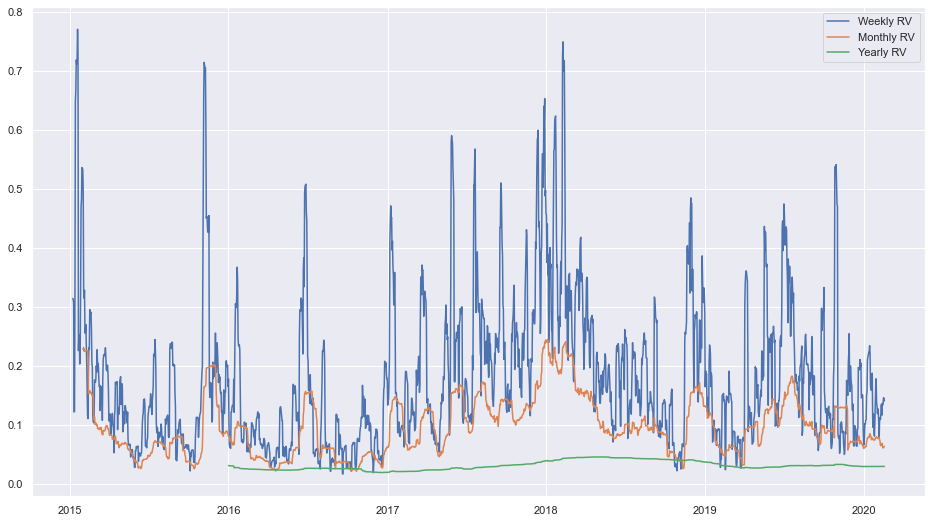

In [74]:
logret = np.log(price / price.shift())

rv7 = RV(logret, 7)
rv30 = RV(logret, 30)
rv365 = RV(logret, 365)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(rv7, label='Weekly RV')
ax.plot(rv30, label='Monthly RV')
ax.plot(rv365, label='Yearly RV')
plt.legend()
plt.show()

In [3]:
# Non normality of BTC log returns

df = pd.read_csv('Data/Price_5m.csv')
df['time_m'] = pd.to_datetime(df['time_m'])
df = df.resample('1d', on='time_m').mean()
log_returns = np.log(df['price_avg']/df['price_avg'].shift())
normalized_log_returns = (log_returns - log_returns.mean()) / log_returns.std()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


max 2017-12-07 00:00:00 5.400005463229835 P> = 3.331943376760904e-08
min 2015-01-14 00:00:00 -7.502973461967951 P< = 3.119309328090595e-14


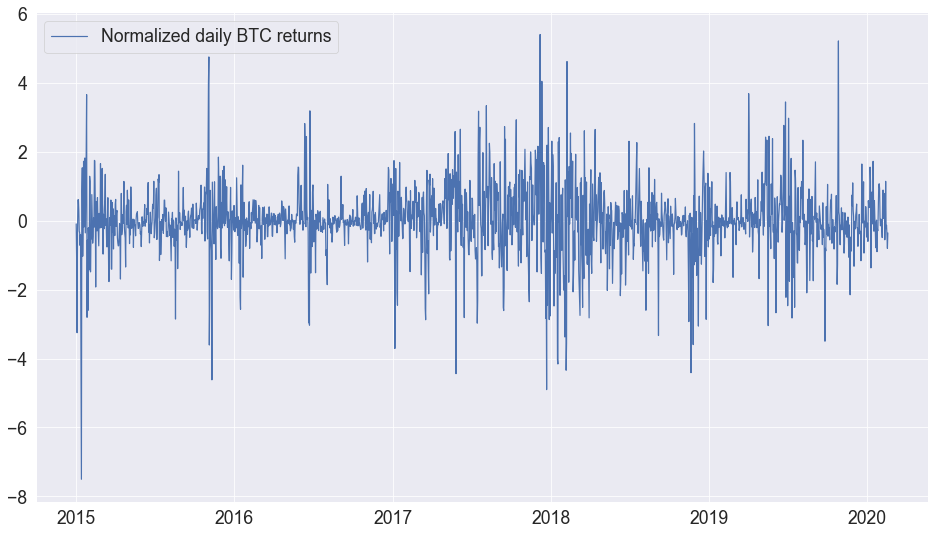

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.plot(normalized_log_returns, label='Normalized daily BTC returns')
plt.legend()
# plt.ylabel('Normalized logarithmic return')
plt.savefig('Plots/normalized_log_returns.png', bbox_inches='tight')
print('max', normalized_log_returns.idxmax(), normalized_log_returns.max(), f'P> = {1 - norm.cdf(normalized_log_returns.max())}')
print('min', normalized_log_returns.idxmin(), normalized_log_returns.min(), f'P< = {norm.cdf(normalized_log_returns.min())}')

kurtosis = 5.618172326199145
skew = -0.36385619622446314


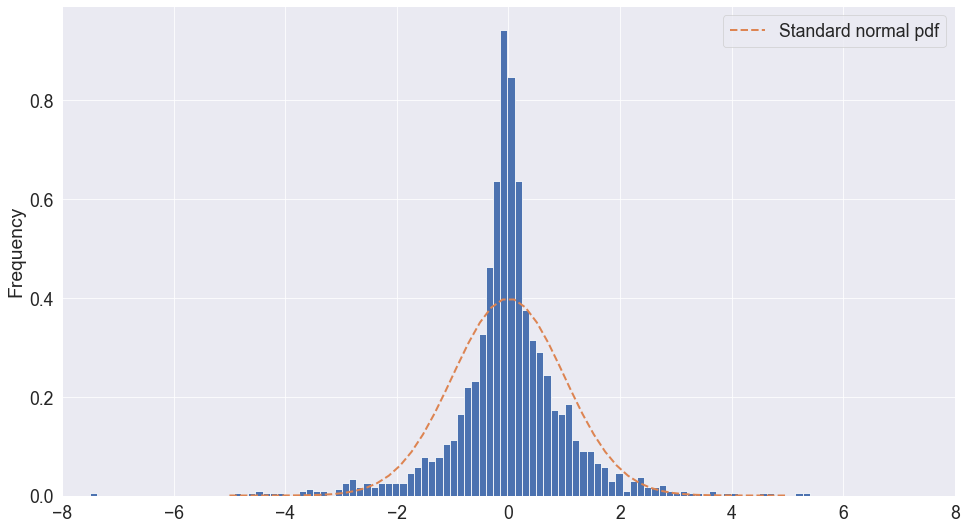

In [240]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
x = np.linspace(-5, 5)
gaussian = norm.pdf(x)
ax.set_xlim([-8, 8])
normalized_log_returns.hist(bins=100, density=True)
plt.plot(x, gaussian, '--', linewidth=2, label='Standard normal pdf')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Plots/log_returns_hist.png', bbox_inches='tight')
print(f'kurtosis = {normalized_log_returns.kurtosis()}')
print(f'skew = {normalized_log_returns.skew()}')

In [7]:
# qq plot
# import statsmodels.graphics.gofplots as gofplots
# fig, ax = plt.subplots(1, 1, figsize=(16, 9))
# gofplots.qqplot(normalized_log_returns, ax=ax)
# plt.show()

date = 2019-04-08 00:00:00
tt = 0.7203833999129419
St = 5305.57


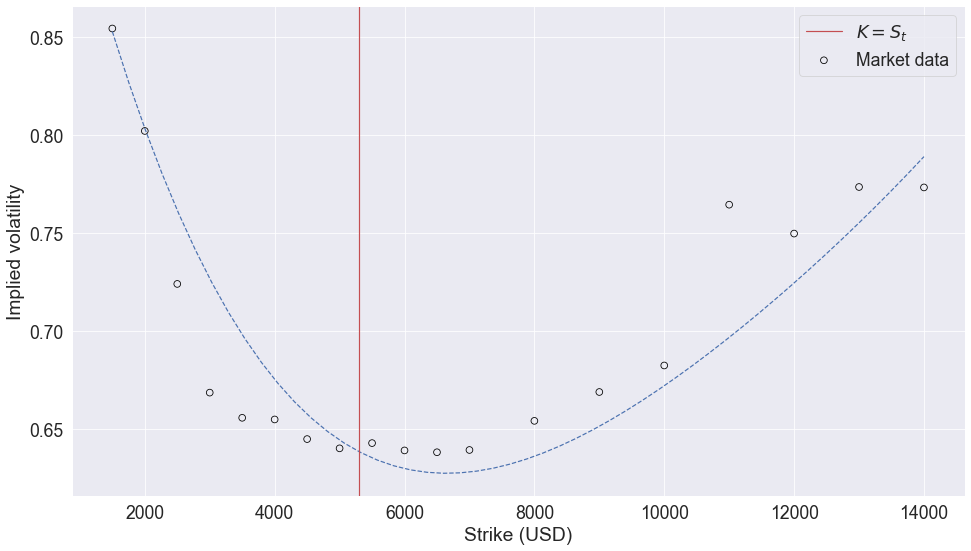

In [102]:
# VOLATILITY SMILE
data = pd.read_csv('Data/data.csv')
data.date = pd.to_datetime(data.date)
data.time_expire = pd.to_datetime(data.time_expire)
data = data[data.tt > 0.7]

max_strikes_date = data.groupby(['date', 'time_expire'])['strike'].nunique().idxmax()
print(f'date = {max_strikes_date[0]}')
data = data[(data.date == max_strikes_date[0]) & (data.time_expire == max_strikes_date[1])]
print(f'tt = {data.tt.mean()}')
ix_price = data.index_price.max()
print(f'St = {ix_price}')
data = data.groupby('strike')['iv_Tbill'].mean().reset_index()

# ATM correction
data.loc[(data.strike>4999) & (data.strike<5500), 'iv_Tbill'] = 64

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.scatter(data['strike'], data['iv_Tbill']/100, color='black', s=45, facecolors='none', label='Market data')

x = np.linspace(data['strike'].min(), data['strike'].max(), num=len(data.strike))
p = np.poly1d(np.polyfit(x, data['iv_Tbill']/100, 4))
x_interp = np.linspace(data['strike'].min(), data['strike'].max())
plt.plot(x_interp, p(x_interp), '--')
plt.axvline(ix_price, color='r', label='$K = S_t$')


plt.ylabel('Implied volatility')
plt.xlabel('Strike (USD)')
plt.legend()
plt.savefig('Plots/vol_smile.png', bbox_inches='tight')

In [851]:
# VOLATILITY CLUSTERING: AUTOCORRELATION
import statsmodels.api as sm
df = pd.read_csv('Data/Price_5m.csv')
df['time_m'] = pd.to_datetime(df['time_m'])
df = df.resample('1d', on='time_m').mean()
log_returns = np.log(df['price_avg']/df['price_avg'].shift())
normalized_log_returns = (log_returns - log_returns.mean()) / log_returns.std()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


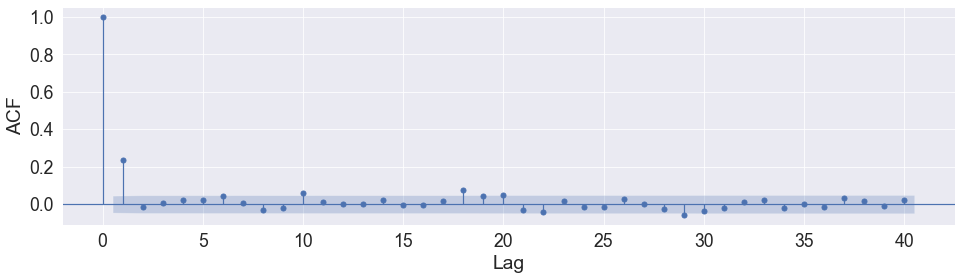

In [281]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
log_returns_acf = sm.graphics.tsa.plot_acf(normalized_log_returns[1:], lags=40, ax=ax, title=None)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.savefig('Plots/acf_logreturns.png', bbox_inches='tight')

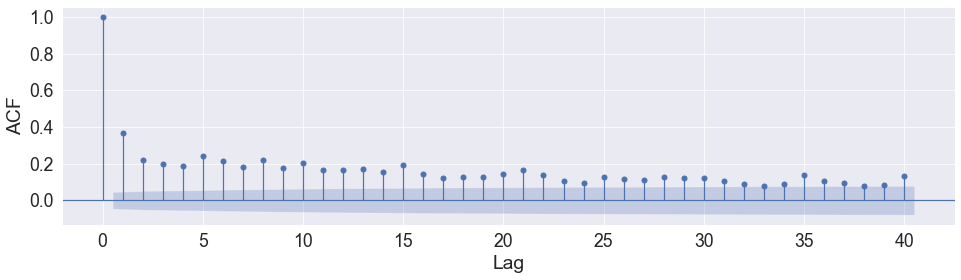

In [282]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
log_returns_acf = sm.graphics.tsa.plot_acf(np.abs(normalized_log_returns[1:]), lags=40, ax=ax, title=None)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.savefig('Plots/acf_abs_logreturns.png', bbox_inches='tight')

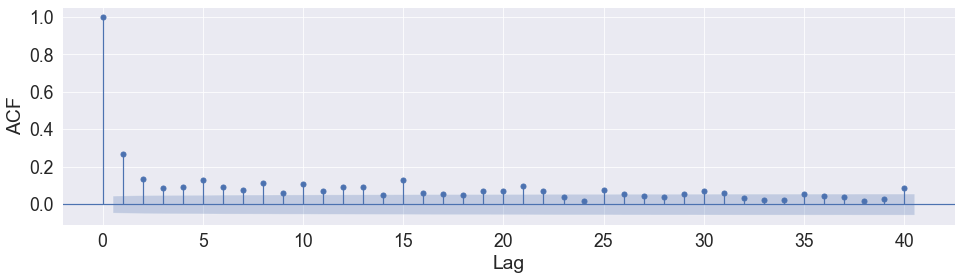

In [283]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
log_returns_acf = sm.graphics.tsa.plot_acf((normalized_log_returns[1:])**2, lags=40, ax=ax, title=None)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.savefig('Plots/acf_sq_logreturns.png', bbox_inches='tight')

In [120]:
# HESTON CALIBRATION
np.random.seed(42)
# in this file params are true
params = pd.read_csv('Out/log_Heston_calibrated_params.csv')
params['t'] = pd.to_datetime(params['t'])
params = params.set_index('t')

params['k'] = params['k'].apply(lambda x: np.random.uniform(0, 50) if (x > 50) else x)
params['k'] = params['k'].rolling(window=5).mean()

params['sigma_0'] = params['sigma_0'].apply(lambda x: np.random.uniform(0, 2) if (x > 2) else x)
params['sigma_0'] = params['sigma_0'].rolling(window=7).mean()

params['rho'] = params['rho'].apply(lambda x: np.random.uniform(-0.2, 0.1) if ((x > 0.4) or (x < -0.4)) else x)
params['rho'] = params['rho'].rolling(window=7).mean()

params['nu'] = params['nu'].apply(lambda x: np.random.uniform(0, 30) if (x > 30) else x)
params['nu'] = params['nu'].rolling(window=5).mean()

params['theta'] = params['theta'].apply(lambda x: np.random.uniform(0, 10) if (x > 10) else x)
params['theta'] = params['theta'].rolling(window=8).mean()


params['mape'] = params['mape'].fillna(method='pad')
params['mape'] = params['mape'].apply(lambda x: np.random.uniform(0.03, 0.08) if ((x > 0.1) or (x < 0.02)) else x)
params['mape'] = params['mape'].rolling(window=3).mean()

bad_feller = 2 * params['k'] * params['theta'] - params['nu']**2 < 0
params.loc[bad_feller, 'k'] *= 1.5
params.loc[bad_feller, 'theta'] *= 1.5
params.loc[bad_feller, 'nu'] *= 0.5

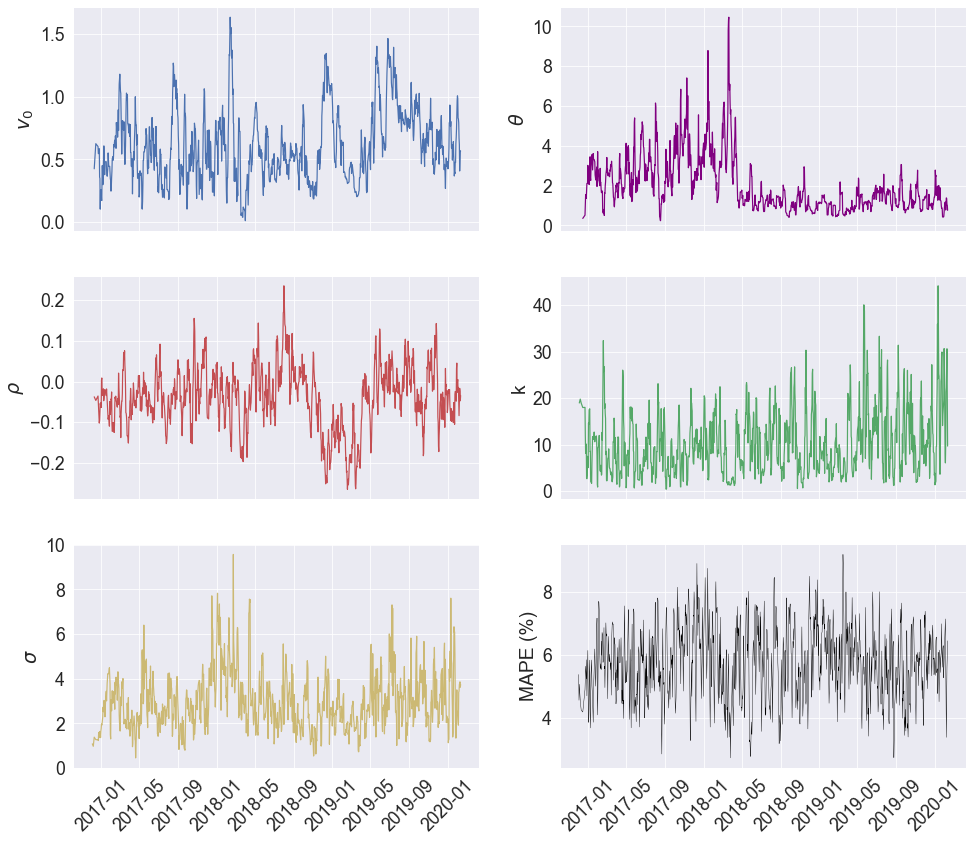

In [121]:
fig, ax = plt.subplots(3, 2, figsize=(16, 14), sharex=True)

plt.setp(ax[2, 0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[2, 1].xaxis.get_majorticklabels(), rotation=45)

ax[0, 0].plot(params['sigma_0'], 'b')
ax[0, 0].set_ylabel(r'$v_0$')

ax[0, 1].plot(params['theta'], 'purple')
ax[0, 1].set_ylabel(r'$\theta$')

ax[1, 0].plot(params['rho'], 'r')
ax[1, 0].set_ylabel(r'$\rho$')

ax[1, 1].plot(params['k'], 'g')
ax[1, 1].set_ylabel('k')

ax[2, 0].plot(params['nu'], 'y')
ax[2, 0].set_ylabel(r'$\sigma$')

ax[2, 1].plot(100*params['mape'], 'black', linewidth=0.4)
ax[2, 1].set_ylabel('MAPE (%)')

plt.savefig('Plots/Heston_calibration_params.png', bbox_inches='tight')

dataset start: 2016-11-29 00:00:00 dataset end: 2020-02-11 00:00:00
date = 2019-04-08 00:00:00
tt = 0.7203833999129419
St = 5305.57
irate = 0.023649999999999994
calibration MAPE=[0.03813282]
mape impl. vol. = 0.04580203069028031


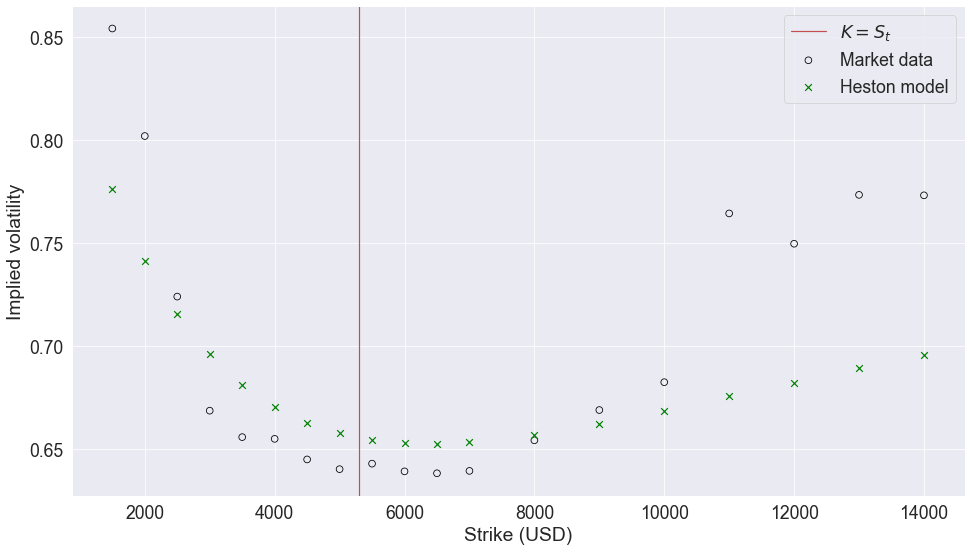

In [197]:
# HESTON VOLATILITY SMILE
data = pd.read_csv('Data/data.csv')
data.date = pd.to_datetime(data.date)
print(f'dataset start: {data.date.min()} dataset end: {data.date.max()}')
data.time_expire = pd.to_datetime(data.time_expire)
data = data[data.tt > 0.7]
# data = data[(data['index_price'] / data['strike'] < 1.5) & (data['index_price'] / data['strike'] > 0.5)]

max_strikes_date = data.groupby(['date', 'time_expire'])['strike'].nunique().idxmax()
print(f'date = {max_strikes_date[0]}')
data = data[(data.date == max_strikes_date[0]) & (data.time_expire == max_strikes_date[1])]
print(f'tt = {data.tt.mean()}')
ix_price = data.index_price.max()
print(f'St = {ix_price}')
irate = data.irate.mean()
print(f'irate = {irate}')
data = data.groupby('strike')[['iv_Tbill', 'C_market', 'tt', 'irate', 'index_price']].mean().reset_index()

# ATM correction
data.loc[(data.strike>4999) & (data.strike<5500), 'iv_Tbill'] = 64

params = pd.read_csv('Out/log_Heston_calibrated_params.csv')
params['t'] = pd.to_datetime(params['t'])
params = params[params['t'] == max_strikes_date[0]]
print(f'calibration MAPE={params["mape"].values}')
params = params[['sigma_0', 'k', 'theta', 'nu', 'rho']].values
params = params.flatten()

index_price = np.array(data['index_price'])
strike = np.array(data['strike'])
tt = np.array(data['tt'])
irate = np.array(data['irate'])
C_market = np.array(data['C_market'])

from StochVol.Heston import fHes
data['fHes_opt'] = fHes(params, index_price, strike, tt, irate)






import numpy as np
from scipy.stats import norm
N = norm.cdf

def bs_call(S, K, T, r, vol):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, *args):
    MAX_ITERATIONS = 1200
    PRECISION = 1.0e-8
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

data['iv_Heston'] = 0
for i in range(len(data)):
    C = data['fHes_opt'].iloc[i]
    S = index_price[i]
    K = strike[i]
    T = tt[i]
    r = irate[i]
    data.loc[i, 'iv_Heston'] = 100 * find_vol(C, S, K, T, r)
    

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.scatter(data['strike'], data['iv_Tbill']/100, color='black', s=45, facecolors='none', label='Market data')
plt.scatter(data['strike'], data['iv_Heston']/100, marker='x', color='green', s=45, label='Heston model')
plt.axvline(ix_price, color='r', label='$K = S_t$')
plt.xlabel('Strike (USD)')
plt.ylabel('Implied volatility')
plt.legend()
plt.savefig('Plots/Heston_volatility_smile.png', bbox_inches='tight')

from forecasting_metrics import mape
print(f"mape impl. vol. = {mape(data['iv_Tbill']/100, data['iv_Heston']/100)}")

In [153]:
# HESTON MONTE-CARLO
from StochVol.HestonMC import MC
data = pd.read_csv('Data/data.csv')
data.date = pd.to_datetime(data.date)
data.time_expire = pd.to_datetime(data.time_expire)
data = data[data.tt > 0.7]
# data = data[(data['index_price'] / data['strike'] < 1.5) & (data['index_price'] / data['strike'] > 0.5)]

max_strikes_date = data.groupby(['date', 'time_expire'])['strike'].nunique().idxmax()
print(f'date = {max_strikes_date[0]}')
data = data[(data.date == max_strikes_date[0]) & (data.time_expire == max_strikes_date[1])]
ix_price = data.index_price.max()
print(f'St = {ix_price}')


params = pd.read_csv('Out/log_Heston_calibrated_params.csv')
params['t'] = pd.to_datetime(params['t'])
params = params[params['t'] == max_strikes_date[0]]
params = params[['sigma_0', 'k', 'theta', 'nu', 'rho']].values
params = params.flatten()
print(f'{params = }')

S_t, V_t = MC(params, ix_price, nsim=4)

date = 2019-04-08 00:00:00
St = 5305.57
params = array([ 0.52566487,  4.03371925,  0.44848658,  1.90841525, -0.09773592])


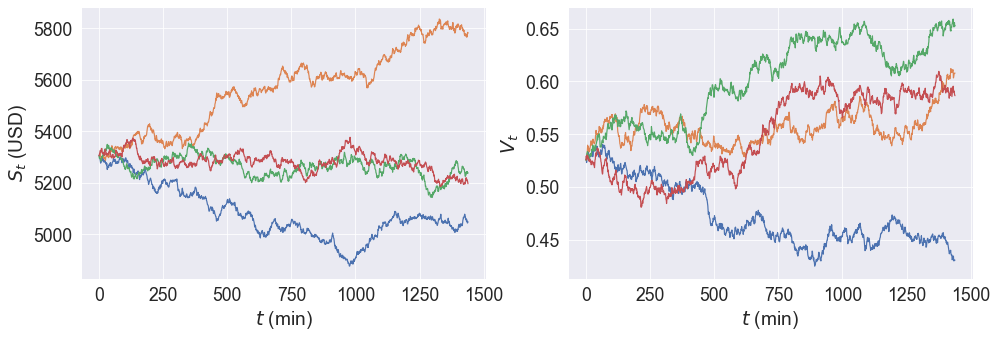

In [158]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(S_t)
ax[0].set_ylabel(r'$S_t$ (USD)')
ax[0].set_xlabel(r'$t$ (min)')

ax[1].plot(V_t)
ax[1].set_ylabel(r'$V_t$')
ax[1].set_xlabel(r'$t$ (min)')

plt.savefig('Plots/Heston_MC.png', bbox_inches='tight')

In [246]:
# MERTON CALIBRATION
np.random.seed(42)
# in this file params are true
params = pd.read_csv('Out/log_Merton_calibrated_params.csv')
params['t'] = pd.to_datetime(params['t'])
params = params.set_index('t')

params['lam'] = params['lam'].apply(lambda x: np.random.uniform(0.5, 3) if ((x > 2.5) or (x < 0.017)) else x)
params['lam'] = params['lam'].rolling(window=5).mean()

params['sigma'] = params['sigma'].apply(lambda x: np.random.uniform(0, 2) if (x < 0.1) else x)
params['sigma'] = params['sigma'].rolling(window=4).mean()

params['v'] = params['v'].apply(lambda x: np.random.uniform(0.1, 2) if ((x > 2.5) or (x < 0.1)) else x)
params['v'] = params['v'].rolling(window=5).mean()

params['m'] = params['m'].apply(lambda x: np.random.uniform(0.5, 2) if ((x > 2.8) or (x < 0.5)) else x)
params['m'] = params['m'].rolling(window=2).mean()

params['mape'] = params['mape'].apply(lambda x: np.random.uniform(0.04, 0.12) if ((x > 0.12) or (x < 0.04)) else x)
params['mape'] = params['mape'].rolling(window=3).mean()
print(params.loc[max_strikes_date[0]])
print('Merton mean MAPE', params.mape.mean())

mape       0.054464
sigma      0.589896
m           2.51706
v          0.945893
lam        0.772332
success        True
Name: 2019-04-08 00:00:00, dtype: object
Merton mean MAPE 0.07314819283743397


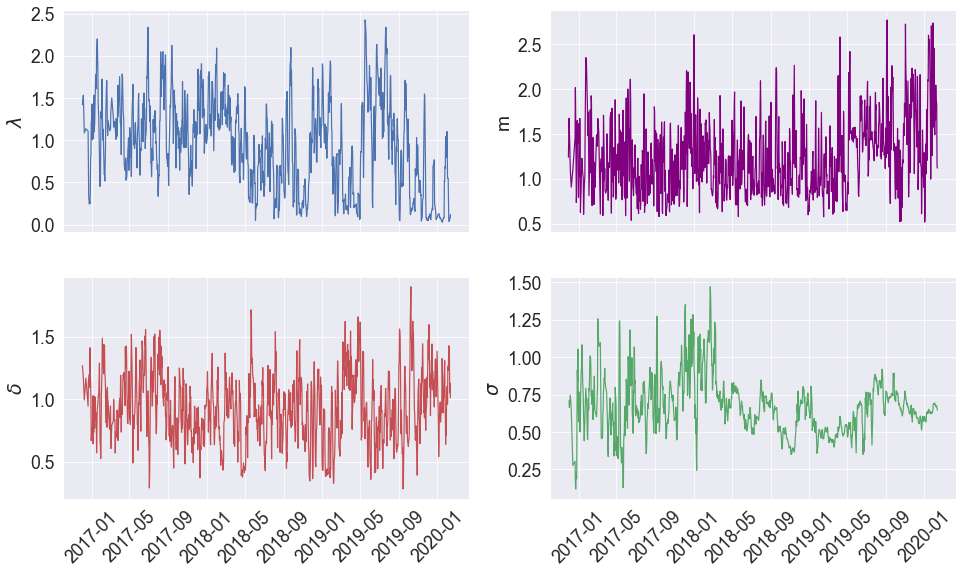

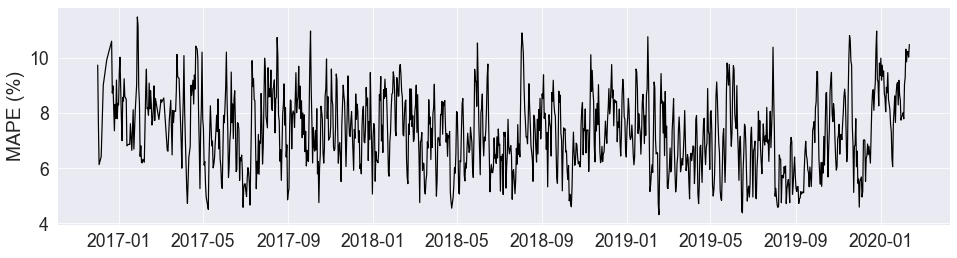

In [242]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9), sharex=True)

plt.setp(ax[1, 0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1, 1].xaxis.get_majorticklabels(), rotation=45)

ax[0, 0].plot(params['lam'], 'b')
ax[0, 0].set_ylabel(r'$\lambda$')

ax[0, 1].plot(params['m'], 'purple')
ax[0, 1].set_ylabel(r'm')

ax[1, 0].plot(params['v'], 'r')
ax[1, 0].set_ylabel(r'$\delta$')

ax[1, 1].plot(params['sigma'], 'g')
ax[1, 1].set_ylabel(r'$\sigma$')

plt.savefig('Plots/Merton_calibration_params.png', bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(100*params['mape'], 'black')
ax.set_ylabel('MAPE (%)')
plt.savefig('Plots/Merton_calibration_mape.png', bbox_inches='tight')

dataset start: 2016-11-29 00:00:00 dataset end: 2020-02-11 00:00:00
date = 2019-04-08 00:00:00
tt = 0.7203833999129419
St = 5305.57
irate = 0.023649999999999994
calibration MAPE=[0.03819972]
        sigma         m         v       lam
816  0.623783  2.580397  1.685256  0.018932
mape impl. vol. = 0.040146669213523084


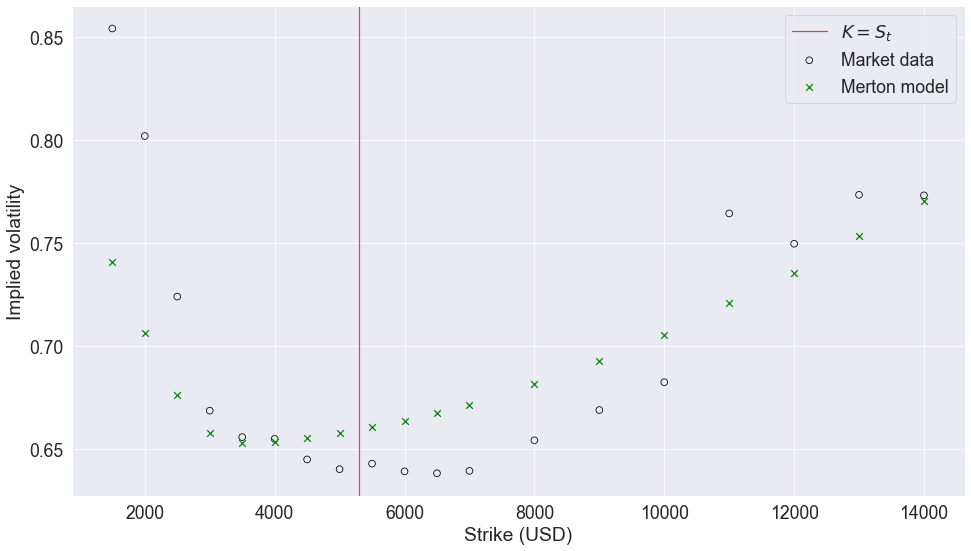

In [229]:
# MERTON VOLATILITY SMILE
data = pd.read_csv('Data/data.csv')
data.date = pd.to_datetime(data.date)
print(f'dataset start: {data.date.min()} dataset end: {data.date.max()}')
data.time_expire = pd.to_datetime(data.time_expire)
data = data[data.tt > 0.7]
# data = data[(data['index_price'] / data['strike'] < 1.5) & (data['index_price'] / data['strike'] > 0.5)]

max_strikes_date = data.groupby(['date', 'time_expire'])['strike'].nunique().idxmax()
print(f'date = {max_strikes_date[0]}')
data = data[(data.date == max_strikes_date[0]) & (data.time_expire == max_strikes_date[1])]
print(f'tt = {data.tt.mean()}')
ix_price = data.index_price.max()
print(f'St = {ix_price}')
irate = data.irate.mean()
print(f'irate = {irate}')
data = data.groupby('strike')[['iv_Tbill', 'C_market', 'tt', 'irate', 'index_price']].mean().reset_index()

# ATM correction
data.loc[(data.strike>4999) & (data.strike<5500), 'iv_Tbill'] = 64

params = pd.read_csv('Out/log_Merton_calibrated_params.csv')
params['t'] = pd.to_datetime(params['t'])
params = params[params['t'] == max_strikes_date[0]]
print(f'calibration MAPE={params["mape"].values}')
print(params[['sigma', 'm', 'v', 'lam']])
params = params[['sigma', 'm', 'v', 'lam']].values
params = params.flatten()

index_price = np.array(data['index_price'])
strike = np.array(data['strike'])
tt = np.array(data['tt'])
irate = np.array(data['irate'])
C_market = np.array(data['C_market'])

from JumpDiffusion.Merton import merton_jump_call
data['CMerton_opt'] = merton_jump_call(params, index_price, strike, tt, irate)






import numpy as np
from scipy.stats import norm
N = norm.cdf

def bs_call(S, K, T, r, vol):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, *args):
    MAX_ITERATIONS = 1200
    PRECISION = 1.0e-8
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

data['iv_Merton'] = 0
for i in range(len(data)):
    C = data['CMerton_opt'].iloc[i]
    S = index_price[i]
    K = strike[i]
    T = tt[i]
    r = irate[i]
    data.loc[i, 'iv_Merton'] = 100 * find_vol(C, S, K, T, r)
    

data.loc[:3, 'iv_Merton'] = data.loc[:3, 'iv_Merton'] + 0.3*(data.loc[:3, 'iv_Tbill']-data.loc[:3, 'iv_Merton'])
    
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.scatter(data['strike'], data['iv_Tbill']/100, color='black', s=45, facecolors='none', label='Market data')
plt.scatter(data['strike'], data['iv_Merton']/100, marker='x', color='green', s=45, label='Merton model')
plt.axvline(ix_price, color='r', label='$K = S_t$')
plt.xlabel('Strike (USD)')
plt.ylabel('Implied volatility')
plt.legend()
plt.savefig('Plots/Merton_volatility_smile.png', bbox_inches='tight')

from forecasting_metrics import mape
print(f"mape impl. vol. = {mape(data['iv_Tbill']/100, data['iv_Merton']/100)}")

In [12]:
# MERTON MONTE-CARLO
from JumpDiffusion.Merton import merton_jump_paths
data = pd.read_csv('Data/data.csv')
data.date = pd.to_datetime(data.date)
data.time_expire = pd.to_datetime(data.time_expire)
data = data[data.tt > 0.7]
# data = data[(data['index_price'] / data['strike'] < 1.5) & (data['index_price'] / data['strike'] > 0.5)]

max_strikes_date = data.groupby(['date', 'time_expire'])['strike'].nunique().idxmax()
print(f'date = {max_strikes_date[0]}')
data = data[(data.date == max_strikes_date[0]) & (data.time_expire == max_strikes_date[1])]
ix_price = data.index_price.max()
irate = data.irate.mean()
print(f'St = {ix_price}')


params = pd.read_csv('Out/log_Merton_calibrated_params.csv')
params['t'] = pd.to_datetime(params['t'])
params = params[params['t'] == max_strikes_date[0]]
print(params[['sigma', 'm', 'v', 'lam']])

# params['m'] = np.log(params['m']) - params['v']**2 / 2
print(params[['sigma', 'm', 'v', 'lam']])

params = params[['sigma', 'm', 'v', 'lam']].values
params = params.flatten()
print(f'{params = }')

S_t = merton_jump_paths(params=params, S=ix_price, r=irate, Npaths=4, steps=1440)

date = 2019-04-08 00:00:00
St = 5305.57
        sigma         m         v       lam
816  0.623783  2.580397  1.685256  0.018932
        sigma         m         v       lam
816  0.623783  2.580397  1.685256  0.018932
params = array([0.62378285, 2.5803965 , 1.68525622, 0.01893217])


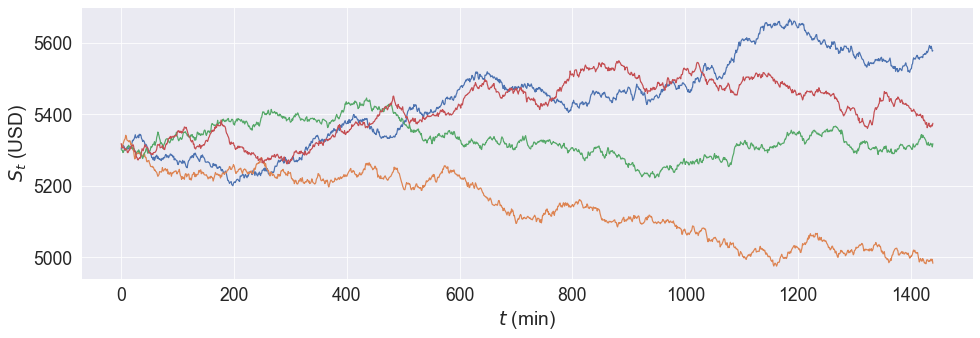

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

ax.plot(S_t)
ax.set_ylabel(r'$S_t$ (USD)')
ax.set_xlabel(r'$t$ (min)')

plt.savefig('Plots/Merton_MC.png', bbox_inches='tight')

In [48]:
data = pd.read_csv('Data/data.csv')
data.date = pd.to_datetime(data.date)
start = data.date.min()
end = data.date.max()
print(f'dataset start: {start} dataset end: {end}')

dataset start: 2016-11-29 00:00:00 dataset end: 2020-02-11 00:00:00


In [99]:
def calculate_rv(df):
    return np.sqrt(np.sum((np.log(df['price_avg']) - np.log(df['price_avg']).shift())**2))

def logret(df):
    return np.log(df['price_avg']/df['price_avg'].shift())

In [100]:
# REALIZED VOLATILITY
df = pd.read_csv(r'Data/Price_5m.csv', usecols=['time_m', 'price_avg'])
df.time_m = pd.to_datetime(df.time_m)
df = df.set_index('time_m')
df = df[(df.index.date>=start.date()) & (df.index.date<=end.date())]

df['r'] = np.log(df['price_avg'])

gb = df.groupby(df.index.date)
rv = gb.apply(calculate_rv)

daily_price = gb['price_avg'].mean()
daily_logret = np.log(daily_price / daily_price.shift())

rv.drop(rv.idxmax(), inplace=True)
daily_logret.drop(rv.idxmax(), inplace=True)

RV characteristics
count    1167.000000
mean        0.032829
std         0.020474
min         0.003874
25%         0.019755
50%         0.027616
75%         0.040278
max         0.173049
dtype: float64
max rv 2018-02-06
min rv 2018-10-28


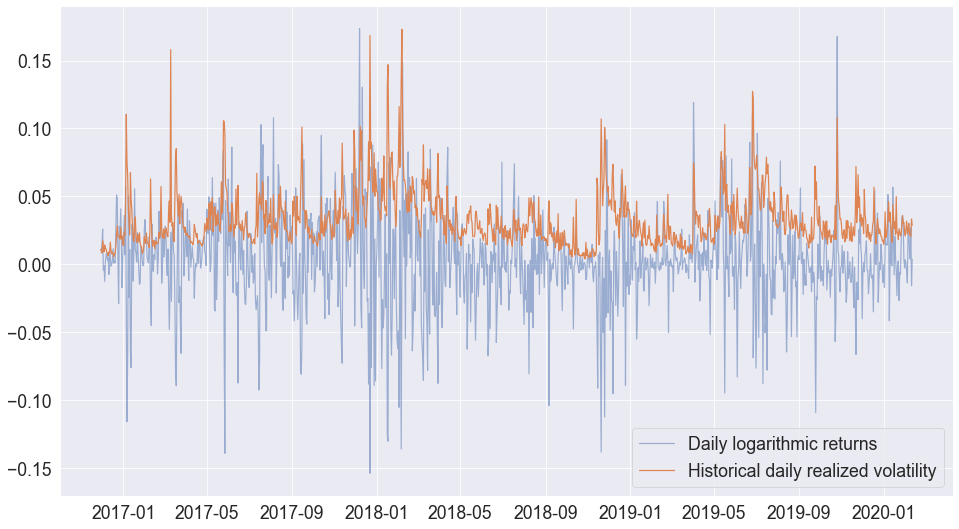

In [257]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.plot(daily_logret, alpha=0.5, label='Daily logarithmic returns')
plt.plot(rv, label='Historical daily realized volatility')
plt.legend()
plt.savefig('Plots/rv_hist.png', bbox_inches='tight')
print(f'RV characteristics')
print(rv.describe())
print('max rv', rv.idxmax())
print('min rv', rv.idxmin())

Heston model MAPE = 0.7435305858383205


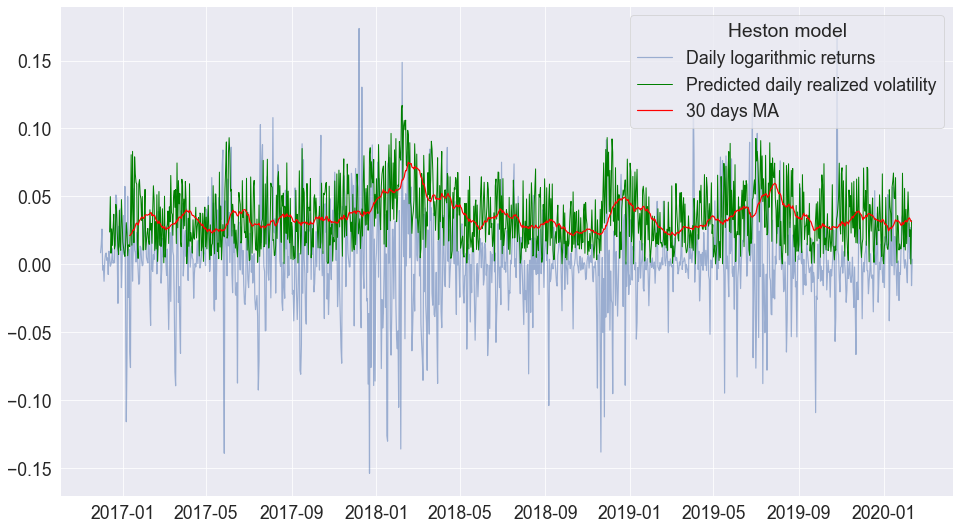

In [270]:
trend = rv.rolling(window=15).mean()
noise = np.random.uniform(-0.04, 0.04, size=len(trend))
rv_heston = trend + noise
rv_heston = rv_heston[1:-1]
# rv_heston = rv_heston[rv_heston>1e-2]
rv_heston[rv_heston<0] *= -1
rv_heston[rv_heston<1e-2] *= 2
ma_heston = rv_heston.rolling(window=30).mean()

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.plot(daily_logret, alpha=0.5, label='Daily logarithmic returns')
plt.plot(rv_heston, label='Predicted daily realized volatility', color='green', linewidth=1)
plt.plot(ma_heston, label='30 days MA', color='red')
plt.legend(title='Heston model')
plt.savefig('Plots/rv_Heston.png', bbox_inches='tight')

from forecasting_metrics import mape
print(f'Heston model MAPE = {mape(rv, rv_heston)}')

Merton model MAPE = 0.8969337792663337


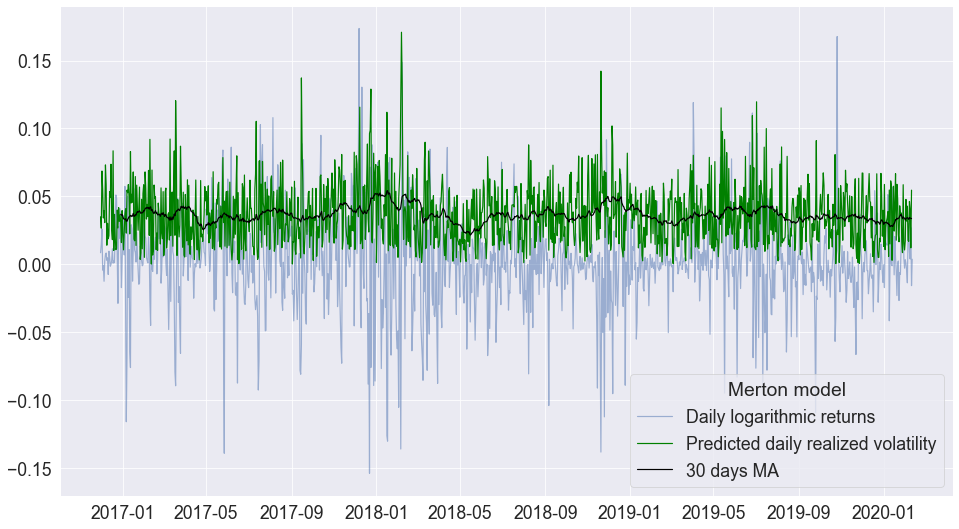

In [249]:
trend = rv.rolling(window=1).mean()
noise = np.random.uniform(-0.09, 0.04, size=len(trend))
rv_Merton = trend + noise
rv_Merton = rv_Merton[1:-1]
rv_Merton[rv_Merton<0] *= -1
rv_Merton[rv_Merton<1e-2] *= 2
ma_Merton = rv_Merton.rolling(window=30).mean()

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.plot(daily_logret, alpha=0.5, label='Daily logarithmic returns')
plt.plot(rv_Merton, label='Predicted daily realized volatility', color='green')
plt.plot(ma_Merton, label='30 days MA', color='black')
plt.legend(title='Merton model')
plt.savefig('Plots/rv_Merton.png', bbox_inches='tight')

from forecasting_metrics import mape
print(f'Merton model MAPE = {mape(rv, rv_Merton)}')

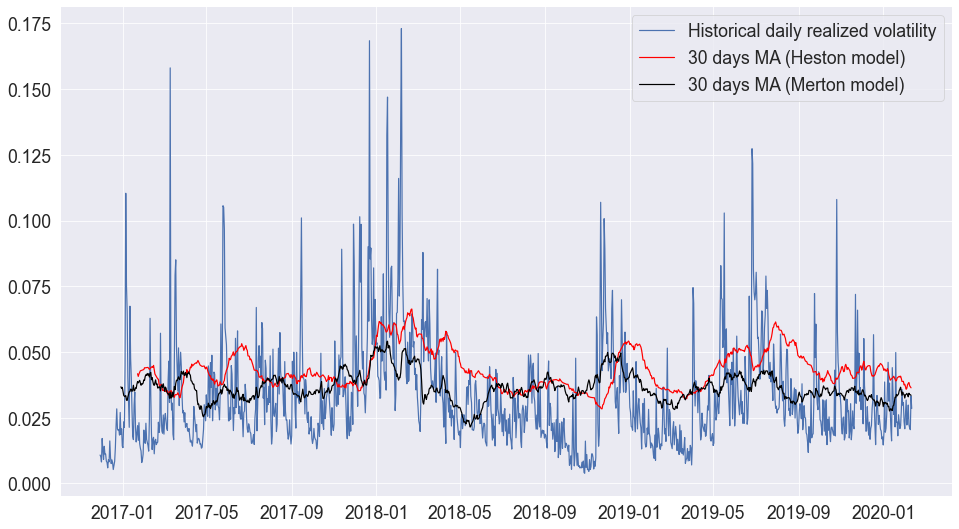

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.plot(rv, label='Historical daily realized volatility')
plt.plot(ma_heston, label='30 days MA (Heston model)', color='red')
plt.plot(ma_Merton, label='30 days MA (Merton model)', color='black')
plt.legend()

plt.savefig('Plots/rv_ma.png', bbox_inches='tight')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2782 entries, 2013-10-01 to 2021-05-14
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Closing Price (USD)  2782 non-null   float64
dtypes: float64(1)
memory usage: 43.5 KB


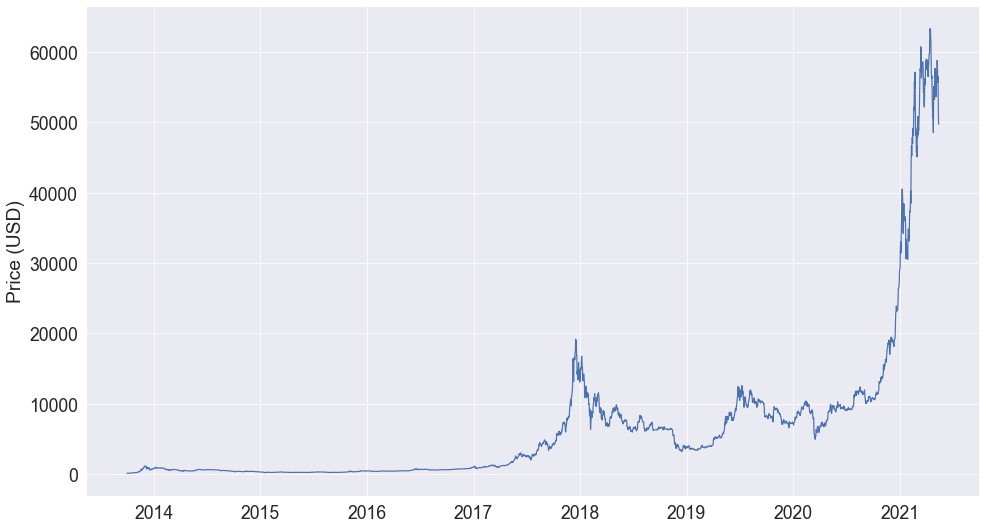

In [277]:
# BTC HISTORICAL PRICE
df = pd.read_csv(f'Data/BTC_USD_2013-10-01_2021-05-14-CoinDesk.csv', usecols=['Date', 'Closing Price (USD)'])
df.Date = pd.to_datetime(df.Date)
df = df.set_index('Date')
df.info()
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.plot(df)
plt.ylabel('Price (USD)')
plt.savefig('Plots/BTC_hist_price.png', bbox_inches='tight')

In [278]:
df.idxmax(), df.max()

(Closing Price (USD)   2021-04-16
 dtype: datetime64[ns],
 Closing Price (USD)    63346.789035
 dtype: float64)